y max è:  882.5554979879159
y min è:  485.2475332180321
y avg è:  682.5269399455598
x max è:  1712.578096770586
x min è:  770.3170881417582
x avg è:  1119.227640681424
[[1014.4054297420049, 620.3539423007098, 53743.0], [1056.8843139034714, 600.3736386247507, 53800.299999999814], [1071.155509591192, 607.0470126815646, 53863.799999999814], [1122.6964444834146, 590.6763743481742, 53929.700000000186], [1143.4432651641864, 617.9107485147358, 53996.700000000186], [1123.6151065257966, 640.6043509799796, 54064.0], [1117.3056472439553, 626.9966732603353, 54117.5], [1144.7731758785662, 603.8971763536379, 54170.200000000186], [1174.2435984291733, 552.3646420756353, 54224.799999999814], [1151.924690076717, 567.9066067016454, 54278.5]]


[['1014.4054297420049', '579.6460576992902', '53743'], ['1056.8843139034714', '599.6263613752493', '53800.299999999814'], ['1071.155509591192', '592.9529873184354', '53863.799999999814'], ['1122.6964444834146', '609.3236256518258', '53929.700000000186'], ['1143.443

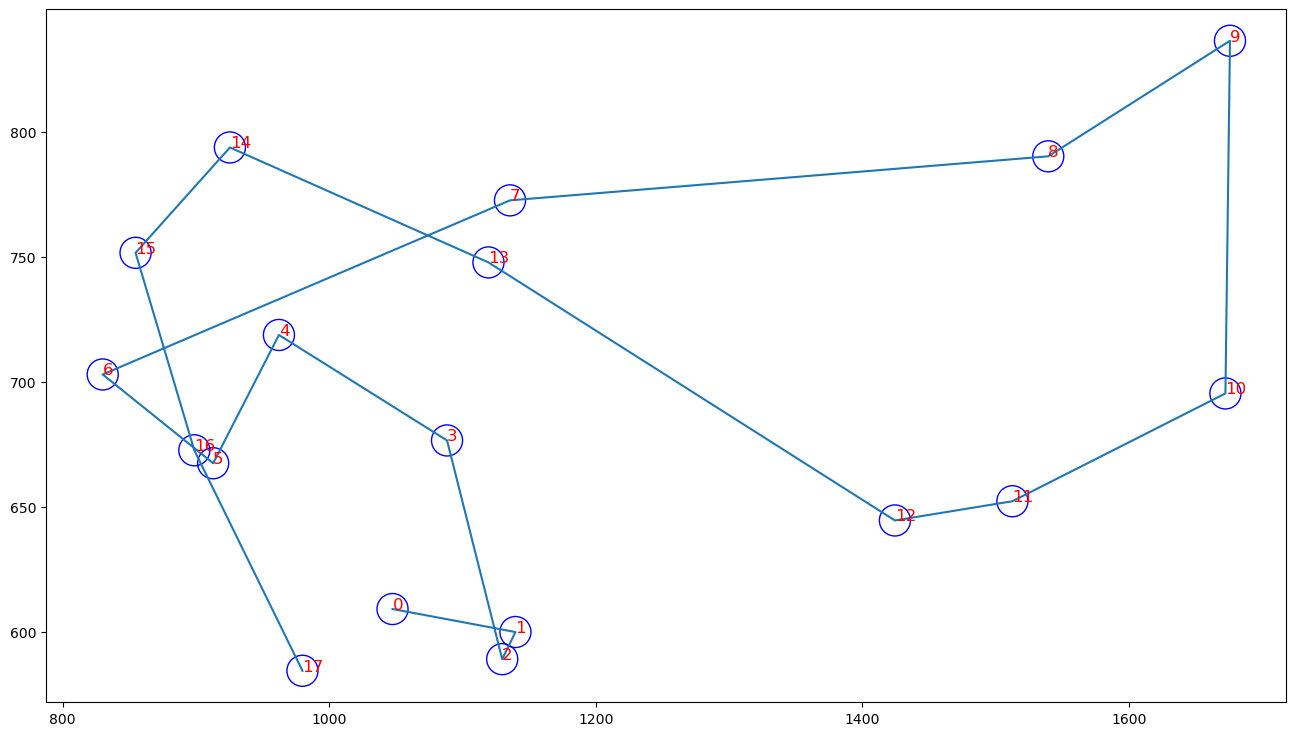

In [1]:
import csv
import turtle
from matplotlib.patches import Circle
from matplotlib.pyplot import * 
import math

with open("..\\csv\\download.csv") as file:

    #read the csv file
    reader_obj = csv.reader(file)

    #create a list to insert the data from the raw data
    list_data = list()
    for row in reader_obj:
        list_data.append(row)

    #pop the first two line which do not contain useful data (for example the name of the columns)
    list_data.pop(0)
    list_data.pop(0)

    #create a list which contains the same data as before but casted to float type in order to
    #use them to create the fixation points in the chart. This list contains tuples made of x coords, 
    # y coords and timestamp. You have to subtract 1200 to the 
    list_circles = list()
    for [a,b,c] in list_data:
        list_circles.append([float(a), (1200 - float(b)), float(c)])


    #it's used to create a list that contains the distance of each pair of points and the time 
    #difference between them to try to create fixation points and saccades. DMAX is the maximum 
    #space distance between two points to consider them a fixation; TMAX is the maximum time
    list_distances = list()
    i = 0
    DMAX = 90
    TMAX = 400
    while i + 1 < len(list_circles):
        num = (list_circles[i+1][0]-list_circles[i][0])**2 + (list_circles[i+1][1]-list_circles[i][1])**2
        square = math.sqrt(num)
        time_difference = list_circles[i+1][2]-list_circles[i][2]
        list_distances.append((round(square, 2), round(time_difference, 2), square < DMAX))
        i=i+1

    #this part is used to find the indexes of the final fixation points
    list_fix_temp = list()
    i = 0
    sum_t = list_distances[0][1]
    while i + 1 < len(list_distances):

        #if the distance between two point is already > DMAX and the delta time is > 80 ms
        # tutti i punti campionati entro 80 ms indifferentemente dalla loro distanza nello 
        # spazio vanno assimilati all'interno di un unico Fixation point
        # la distanza temporale di campionamento è intorno ai 40 ms, quindi nel caso in cui 
        # siano di per sé troppo lontani Prendiamo i tre punti successivi e li includiamo 
        # in un unico Fixation point dato che la distanza temporale di questi tre punti si 
        # aggira intorno agli 80 ms più o meno qualche millisecondo.la distanza spaziale 
        # in questo caso non ci interessa
        if not list_distances[i][2] and i + 3 < len(list_distances):
            # aggrego i tre punti e non passo l'iterazione successiva ma tre successive perché 
            # i punti di mezzo li ho già inseriti in un Fixation
            list_fix_temp.append((i, i+1, i+2))
            sum_t = list_distances[i+3][1]
            #print("primo if, t e i sono " + str(i) + ", " + str(i+1) + ", " + str(i+2) + ", "+ str(i+3))
            i=i+3

        else:
            #Negli altri casi invece prendo il primo punto a disposizione e lo utilizzo 
            # come possibile Fixation point. Vado quindi a determinare la distanza tra questo 
            # punto e tutti i successivi fino a quando o la distanza degll'iesimo punto è 
            # maggiore di DMAX, Oppure il tempo di campionamento a superato i 400 ms. 
            # Successivamente per ogni Fixation point andrò a calcolare la media di tutti 
            # i punti andando a trovare il punto medio e utilizzando quello come Fixation finale

            j = i
            while i + 1 < len(list_distances):

                num = (list_circles[i+1][0]-list_circles[j][0])**2 + (list_circles[i+1][1]-list_circles[j][1])**2
                square = math.sqrt(num)
                time_difference = list_circles[i+1][2]-list_circles[j][2]

                if square < DMAX and time_difference <= TMAX:
                    
                    list_fix_temp.append((j, i+1))
                    #print("while, t e i sono " + str(j) + ", " + str(i+1) + ", " + str(i+1))
                    i = i + 1
                
                else: 
                    #print("sono nel while + else")
                    i = i + 1
                    break

    #used to cast the tuples of indexes contained in the previous list into sets of indexes
    list_fix = list()
    i = 0
    for elem in list_fix_temp:
        list_fix.append(set(elem))

    #each set is checked to join the sets that represent the same fixation point
    while i + 1 < len(list_fix):
        if len(list_fix[i].intersection(list_fix[i+1])) > 0:
            j = i
            while i + 1 < len(list_fix) and len(list_fix[j].intersection(list_fix[i+1])) > 0:
                list_fix[j] = list_fix[j].union(list_fix[i+1])
                list_fix.pop(i+1)
        else:
            i=i+1  

    #eventually, with this part, for every set (that represents the points that should be considered 
    # as the same fixation point), it's calculated the medium point to create the final fixation point
    list_fix_points = list()
    for fix_set in list_fix:
        list_x = list()
        list_y = list()
        for ind in fix_set:
            list_x.append(list_circles[ind][0])
            list_y.append(list_circles[ind][1])
        t = (sum(list_x)/len(list_x), sum(list_y)/len(list_y))
        list_fix_points.append(t)

    '''
    #setting of the graph 
    #xlim(0 , 2560) 
    #ylim(0 , 1440) 
    f = figure()
    f.set_figwidth(16)
    f.set_figheight(9)

    #with this cycle it draw circles starting from the points in the list, using them as centers
    for center in list_circles:
        scatter(center[0], center[1], s=500, facecolors='none', edgecolors='blue')

    #cycle used to enumerate all the circles 
    i = 0
    for cir in list_circles:
        text(cir[0], cir[1], str(i), color="red", fontsize=12)
        i=i+1
    '''
    

    



    '''
    
    '''

    #setting of the graph 
    
    f = figure()
    f.set_figwidth(16)
    f.set_figheight(9)
    


    #shows the fixation points
    for center in list_fix_points:
        scatter(center[0], center[1], s=500, facecolors='none', edgecolors='blue')

    #cycle used to enumerate all the circles 
    i = 0
    for cir in list_fix_points:
        text(cir[0], cir[1], str(i), color="red", fontsize=12)
        i=i+1

        
        
    #shows the saccades
    list_x = list()
    list_y = list()
    for fix in list_fix_points:
        list_x.append(fix[0])
        list_y.append(fix[1])
    plot(list_x, list_y)
    
    '''
    print(*list_circles[:3], sep = "\n")
    print("\n")
    print(*list_distances[:3], sep = "\n")
    print("\n")
    print(*list_fix_temp[:3], sep = "\n")
    print("\n")
    print(*list_fix[:3], sep = "\n")
    print("\n")
    print(*list_fix_points[:3], sep = "\n")
    '''

    '''
    
    '''

    max = 0
    min = 10000
    avg = 0
    for elem in list_circles:
        if elem[1] > max:
            max = elem[1]
        if elem[1] < min:
            min = elem[1]
        avg += elem[1]
    avg = avg / len(list_circles)
    print("y max è: ", max)
    print("y min è: ", min)
    print("y avg è: ", avg)
    
    max = 0
    min = 10000
    avg = 0
    for elem in list_circles:
        if elem[0] > max:
            max = elem[0]
        if elem[0] < min:
            min = elem[0]
        avg += elem[0]
    avg = avg / len(list_circles)
    print("x max è: ", max)
    print("x min è: ", min)
    print("x avg è: ", avg)

    print(list_circles[:10])
    print("\n")
    print(list_data[:10])
    print("\n")
    print(list_distances[:10])

    show()
    '''savefig('GazePoints.png')'''


    